# Problem statement

**Boom bikes** a bike sharing company, provides bike for money or free to individuals. The company has seen dip during the corona pandemic and want to regain to sustain in the market.
<br/>
The company wants to understand 
1. The variables which are significant in predicting the demand for rentals.
2. How variables describe bike demands.

Steps need to be addressed
 
 ##### 1. Read and Understand Data
 ##### 2. Visualize Data
 ##### 3. Model building
 ##### 4. Residual Analysis
 ##### 5. Evaluate and test the model

### Step 1: Read and Understand the data

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from statsmodels import api as sm
from statsmodels import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

import math
import warnings

warnings.filterwarnings(action='ignore')

In [5]:
day_df = pd.read_csv('day.csv', index_col='instant')

In [6]:
day_df.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [7]:
weather_sit_dict = {
    1: 'Few clouds',
    2: 'Mist',
    3: 'Light Snow',
    4: 'Heavy Rain'
}
season_dict =  {
    1:'spring', 
    2:'summer', 
    3:'fall', 
    4:'winter'
}

day_df['weathersit'] = day_df['weathersit'].replace(weather_sit_dict, regex=True)
day_df['season'] = day_df['season'].replace(season_dict, regex=True)

In [8]:
day_df['season'].value_counts()

season
fall      188
summer    184
spring    180
winter    178
Name: count, dtype: int64

In [9]:
day_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 730 entries, 1 to 730
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      730 non-null    object 
 1   season      730 non-null    object 
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    int64  
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    int64  
 6   workingday  730 non-null    int64  
 7   weathersit  730 non-null    object 
 8   temp        730 non-null    float64
 9   atemp       730 non-null    float64
 10  hum         730 non-null    float64
 11  windspeed   730 non-null    float64
 12  casual      730 non-null    int64  
 13  registered  730 non-null    int64  
 14  cnt         730 non-null    int64  
dtypes: float64(4), int64(8), object(3)
memory usage: 91.2+ KB


#### Drop columns

In [11]:
day_df.drop(labels=['casual', 'registered'], axis=1, inplace=True)

<span style='color: green'>dropped **casual** and **registered** columns as they are summed up to our target variable **cnt** </span>

#### Data type conversions 

In [14]:
day_df['dteday'] = pd.to_datetime(day_df['dteday'], format='%d-%m-%Y')

#### Null checks

In [16]:
day_df.isna().sum()

dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

<span style='color: green'>**No nulls in the data** </span>

#### Check duplicates

In [19]:
day_df = day_df.drop_duplicates()

In [20]:
day_df.duplicated().sum()

0

#### Feature Engineering

In [22]:
day_df['weekday_2'] = day_df['dteday'].dt.day_name().str.slice(0,3)
day_df['mnth_2'] = day_df['dteday'].dt.month_name().str.slice(0,3)

d1 = {True: 1, False:0}
day_df['weekend'] = (day_df['dteday'].dt.weekday >=5).replace(d1, regex=True)

# day_df[day_df['weekday'] != day_df['weekday_2']]

In [23]:
day_df[day_df['weekday'] != day_df['dteday'].dt.weekday][['weekday', 'weekday_2']]

,weekday,weekday_2
instant,,
1,6,Mon
2,0,Tue
3,1,Wed
4,2,Thu
5,3,Fri
...,...,...
420,5,Sun
421,6,Mon
422,0,Tue


<span style='color:brown'> incorrect values in weekday from **1-424 rows**</span>

### Visualize the data

#### Uni variate analysis

##### Box plots

In [28]:
cat_cols = ['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'season', 'weathersit']
numeric_cols = ['temp', 'atemp', 'hum', 'windspeed']
target = ['cnt']

In [29]:
def get_plt_rows_cols(features, plt_cols):
    n_rows = math.ceil(len(features))//plt_cols
    n_cols = plt_cols
    return n_rows, n_cols

def box_plots(x_vars=[], df=None):
    if len(df)==0 or len(x_vars)==0: 
        return None
    n_rows, n_cols = get_plt_rows_cols(x_vars, 4)
    plt.figure(figsize=(n_cols**2, n_rows*n_cols))
    for i in range(len(x_vars)):
        ax = plt.subplot(n_rows, n_cols, i+1)
        ax.set(title=x_vars[i])
        ax.set_ylabel(ylabel='')
        sns.boxplot(y=x_vars[i], data=df, ax=ax)

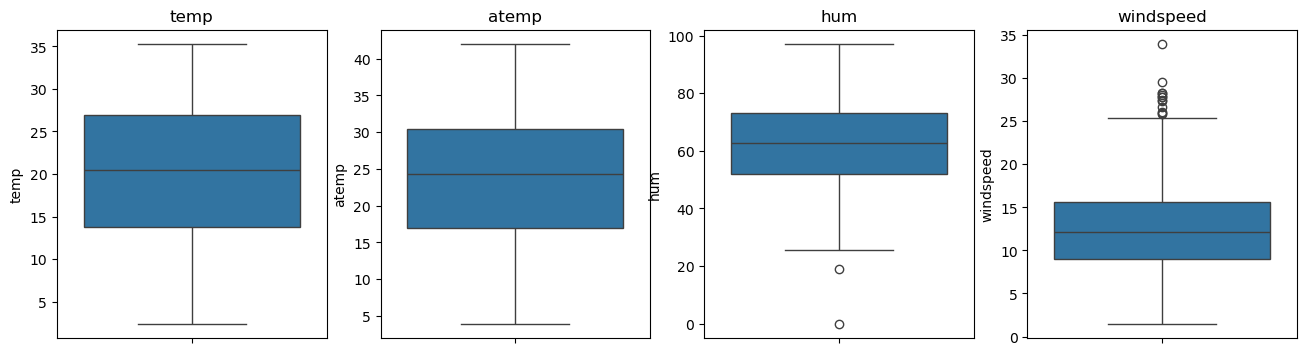

In [30]:
box_plots(numeric_cols, day_df)

<Axes: ylabel='cnt'>

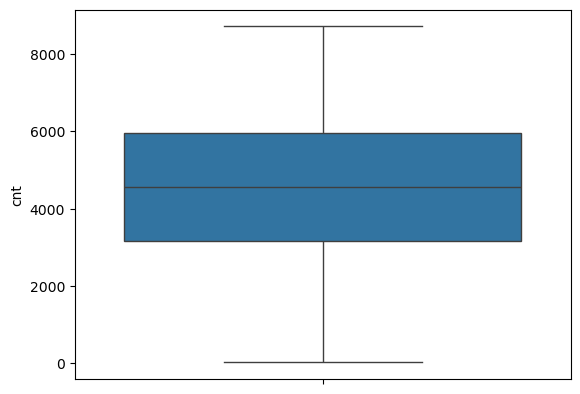

In [31]:
sns.boxplot(data=day_df, y=target[0])

In [32]:
# sns.boxplot(x='yr', y='cnt', data=day_df)

#### Multi variate analysis

<Axes: xlabel='dteday', ylabel='cnt'>

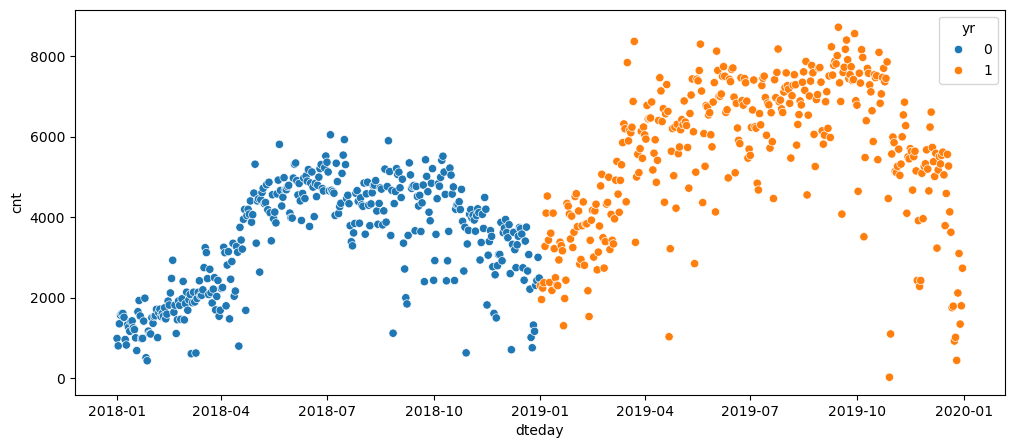

In [34]:
plt.figure(figsize=(12,5))
sns.scatterplot(x='dteday', y='cnt', data=day_df, hue='yr')

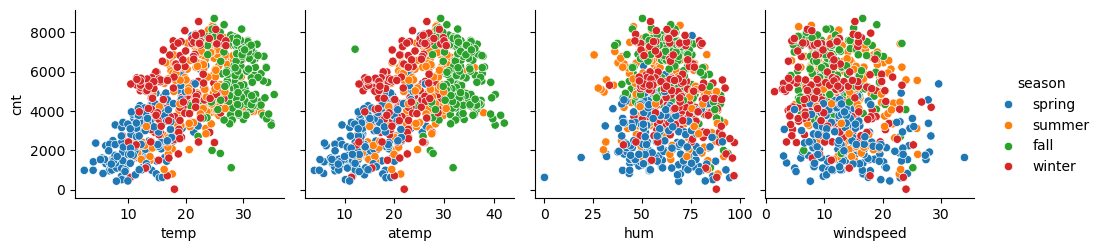

In [35]:
sns.pairplot(x_vars=numeric_cols, y_vars=target, data=day_df, hue='season')
plt.show()

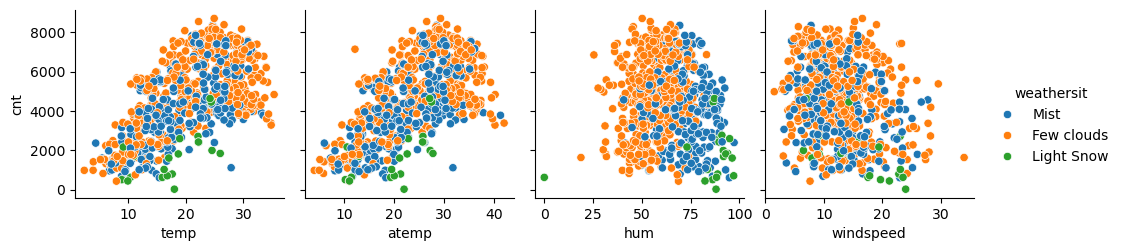

In [36]:
sns.pairplot(x_vars=numeric_cols, y_vars=target, data=day_df, hue='weathersit')
plt.show()

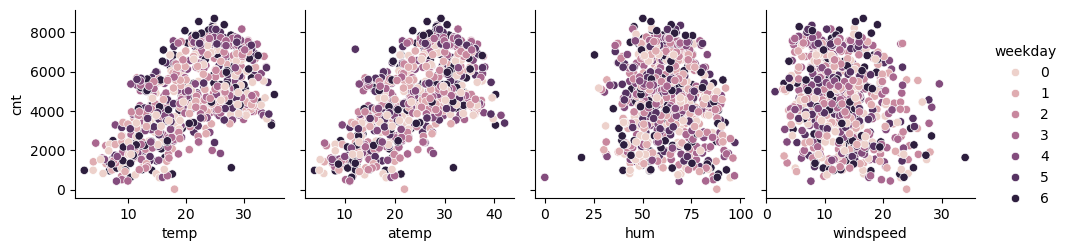

In [37]:
sns.pairplot(x_vars=numeric_cols, y_vars=target, data=day_df, hue='weekday')
plt.show()

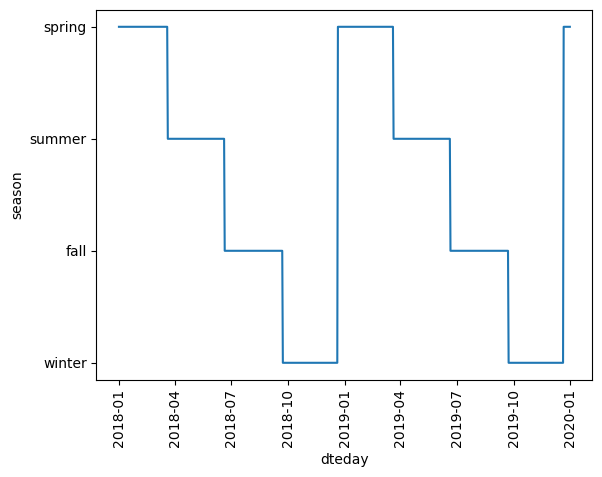

In [38]:
sns.lineplot(x='dteday', y='season', data=day_df)
plt.tick_params(axis='x', labelrotation=90)
plt.show()

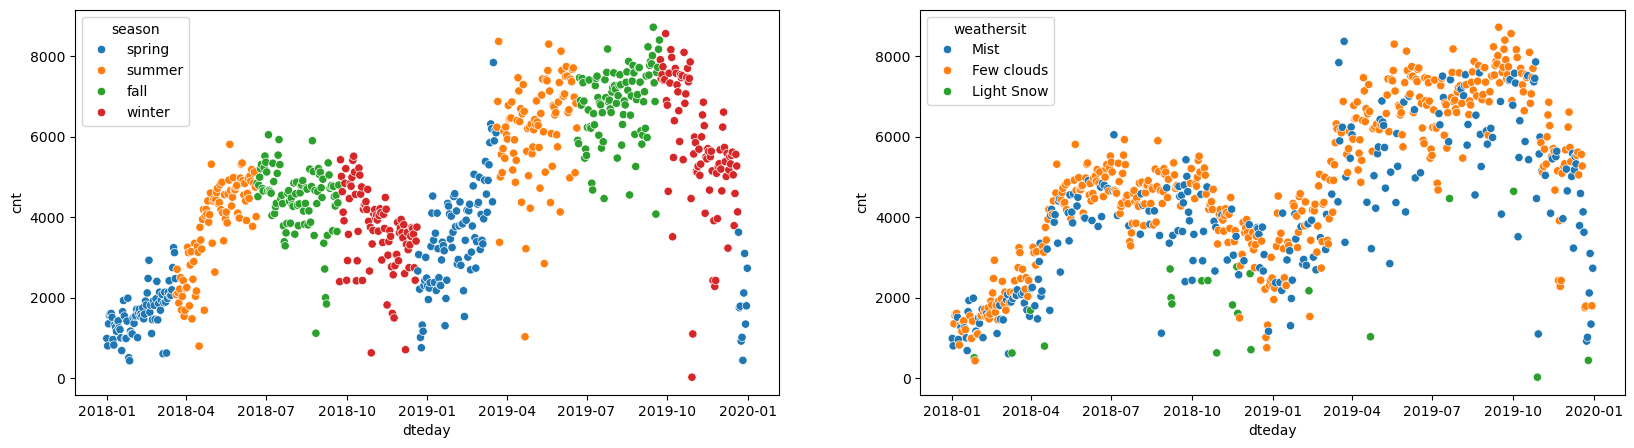

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))
sns.scatterplot(x='dteday', y='cnt', data=day_df, hue='season', ax=axs[0])
sns.scatterplot(x='dteday', y='cnt', data=day_df, hue='weathersit', ax=axs[1])
plt.show()

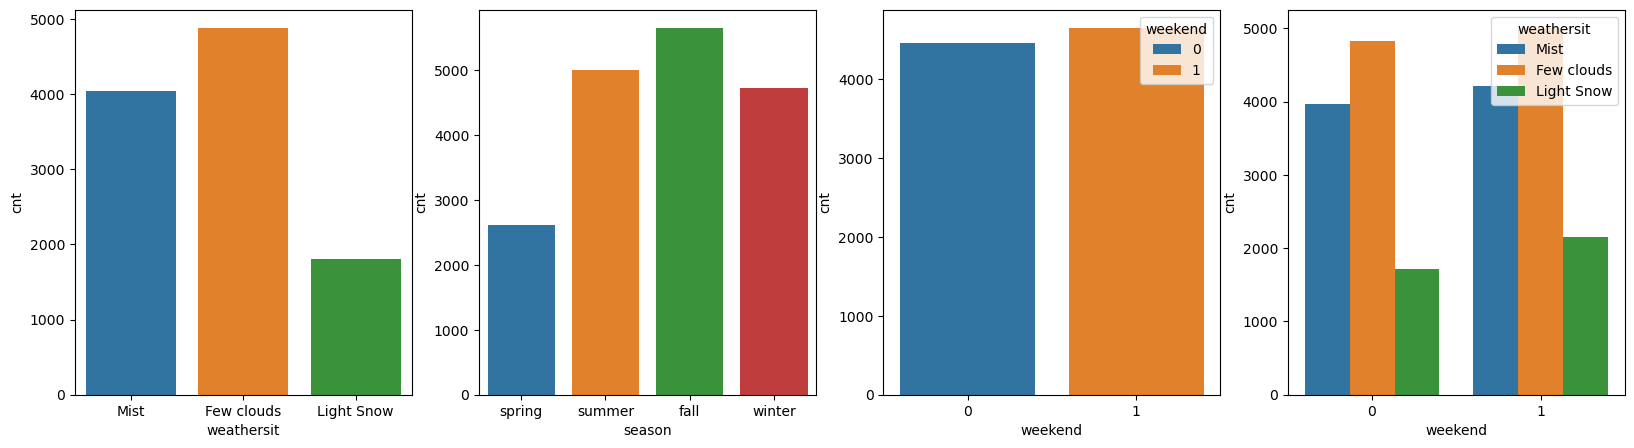

In [40]:
def bar_plots(x_vars, y_var, df, hues = []):
    n_rows, n_cols = get_plt_rows_cols(x_vars, 4)
    plt.figure(figsize=(20, 5*n_rows))
    for i in range(len(x_vars)):
        ax = plt.subplot(n_rows, n_cols, i+1)
        if(hues[i] == ''):
            sns.barplot(data=df, x=x_vars[i], y=y_var, errorbar=None,ax=ax, hue=x_vars[i])
        else:
            sns.barplot(data=df, x=x_vars[i], y=y_var, errorbar=None, hue=hues[i],ax=ax)
    

bar_plots(x_vars=['weathersit', 'season', 'weekend', 'weekend'],
         y_var='cnt',
         df=day_df,
         hues=['', '', '','weathersit'])

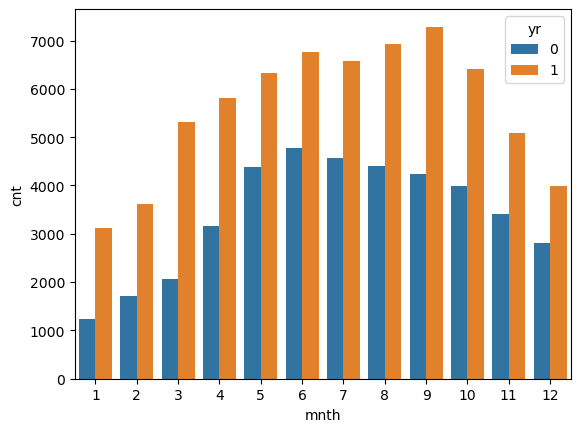

In [41]:
sns.barplot(x='mnth', y='cnt',hue='yr', data=day_df, errorbar=None)
plt.show()

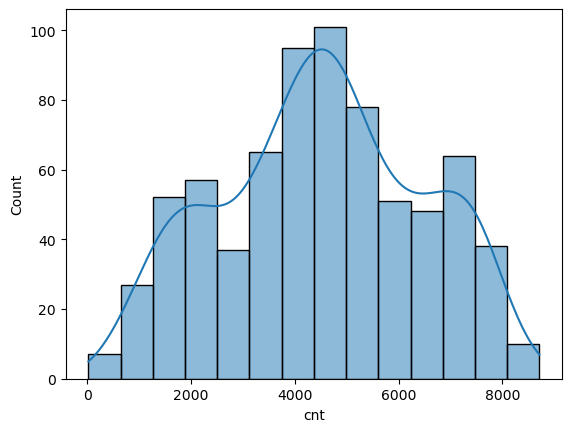

In [42]:
sns.histplot(data=day_df, x='cnt', kde=True)
plt.show()

##### Create dummies for category columns

In [44]:
season_df = pd.get_dummies(day_df['season'], dtype=int, drop_first=True)
weathersit_df = pd.get_dummies(day_df['weathersit'], dtype=int, drop_first=True)
mnth_df = pd.get_dummies( day_df['mnth_2'], drop_first=True, dtype=int)
weekday_df = pd.get_dummies(day_df['weekday_2'], drop_first=True, dtype=int)

In [45]:
final_df = pd.concat([day_df, season_df, weathersit_df, mnth_df, weekday_df], axis=1)

##### dropping the categorical columns and making the final dataframe

In [47]:
final_df = final_df.drop(labels=['season', 'weathersit', 'weekday', 'mnth', 'weekday_2', 'mnth_2', 'dteday' ], axis=1)

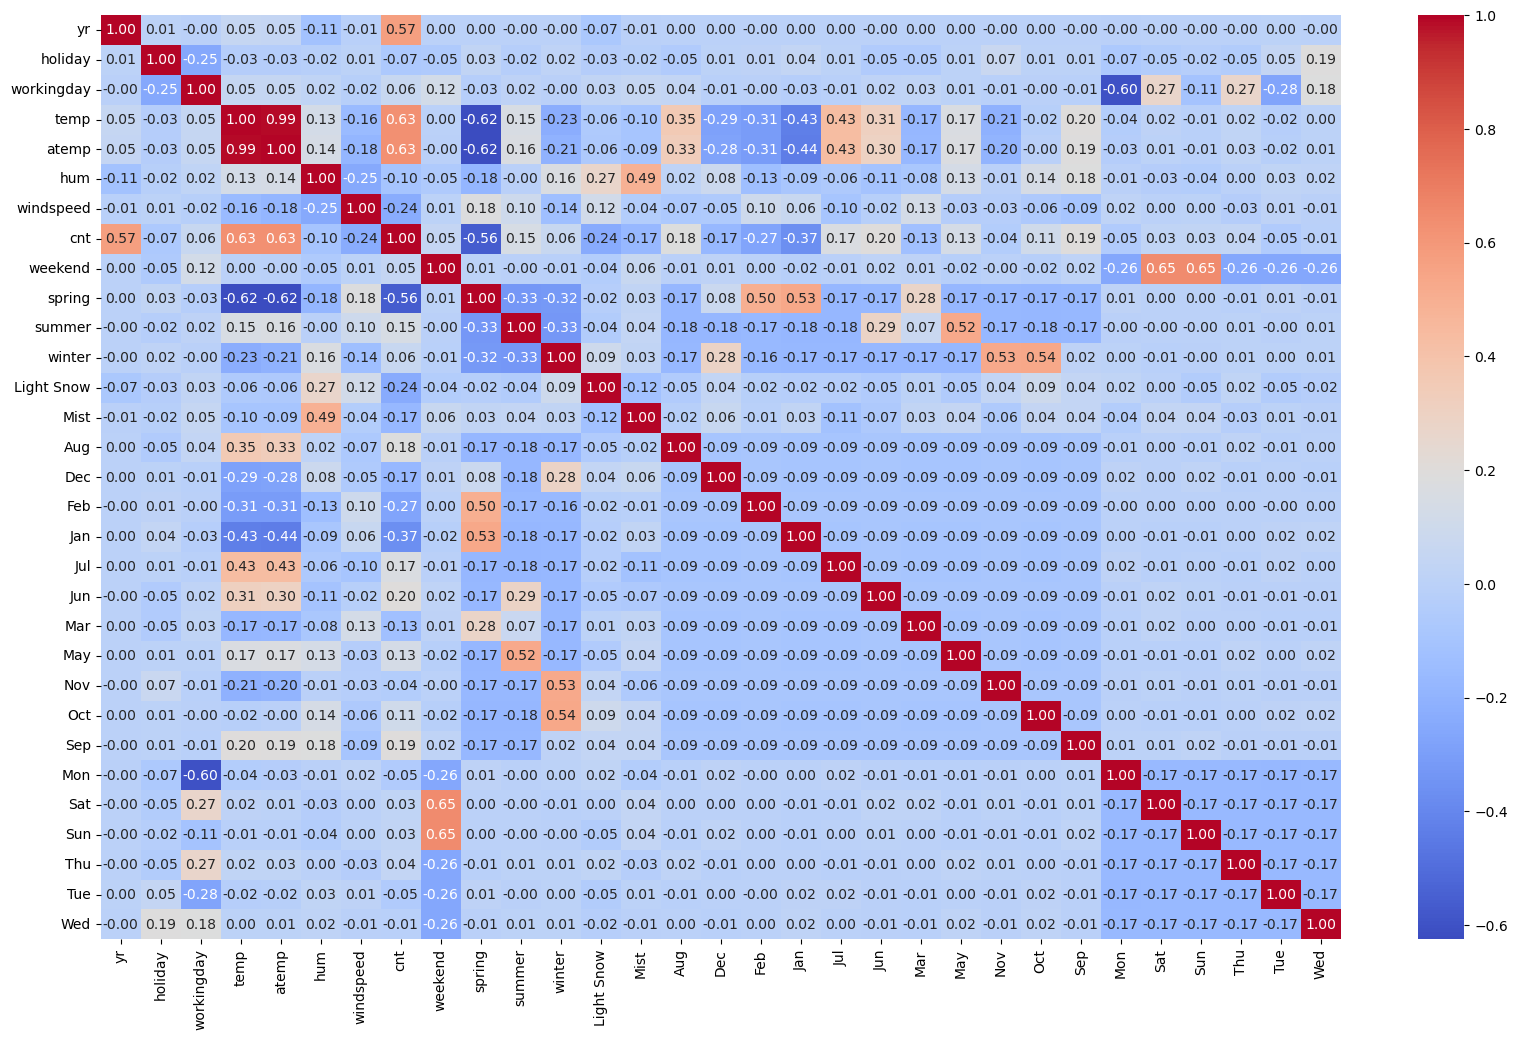

In [48]:
plt.figure(figsize=(20, 12))
sns.heatmap(final_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [49]:
def test_train_split_data(cols=[]):
    cols = cols if len(cols) == 0 else cols.tolist() + ['cnt']
    X_train, X_test = train_test_split(final_df if len(cols) == 0 else final_df[cols], random_state=42, train_size=0.75)
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    return (X_train, X_test)

In [50]:
X_train, X_test = test_train_split_data()
scaler = MinMaxScaler()
X_train[numeric_cols+target] = scaler.fit_transform(X_train[numeric_cols+target])

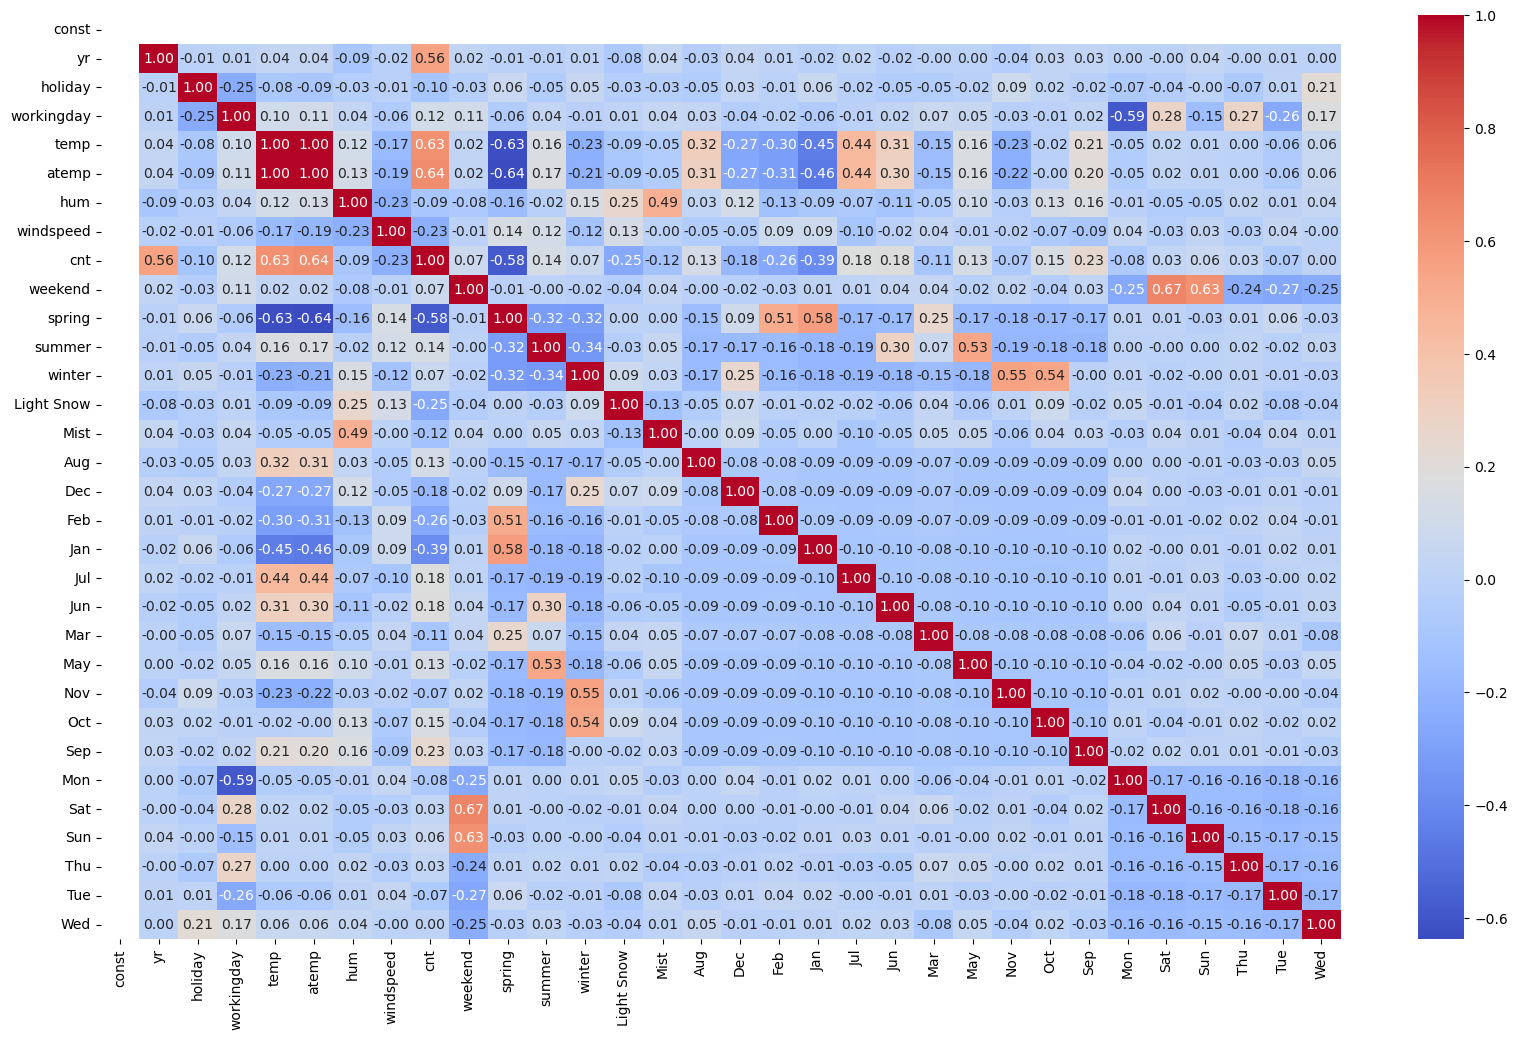

In [51]:
plt.figure(figsize=(20, 12))
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

### Step 3: Model building

In [53]:
y_train = X_train.pop('cnt')

##### Using RFE and selecting 15 features and then manually picking the features

In [55]:
rfe_1 = RFE(LinearRegression(), n_features_to_select=15)
rfe_1.fit(X_train, y_train)
rfe_df = pd.DataFrame({
    'features': X_train.columns.values,
    'selected': rfe_1.support_,
    'ranking': rfe_1.ranking_
})

rfe_df.sort_values(by='ranking', ascending=True).reset_index()

,index,features,selected,ranking
0,15,Dec,True,1
1,20,Mar,True,1
2,22,Nov,True,1
3,13,Mist,True,1
4,12,Light Snow,True,1
5,11,winter,True,1
6,18,Jul,True,1
7,24,Sep,True,1
8,9,spring,True,1
9,6,hum,True,1


In [56]:
rfe_cols = rfe_1.get_feature_names_out()
rfe_cols

array(['yr', 'holiday', 'temp', 'atemp', 'hum', 'windspeed', 'spring',
       'winter', 'Light Snow', 'Mist', 'Dec', 'Jul', 'Mar', 'Nov', 'Sep'],
      dtype=object)

In [57]:
X_train, X_test = test_train_split_data(rfe_cols)
y_train = X_train.pop('cnt')

ols_model_1 = sm.OLS(y_train, X_train).fit()
ols_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     188.0
Date:                Wed, 26 Feb 2025   Prob (F-statistic):          3.93e-201
Time:                        20:13:26   Log-Likelihood:                -4413.2
No. Observations:                 547   AIC:                             8858.
Df Residuals:                     531   BIC:                             8927.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2862.9195    324.715      8.817      0.000    2225.035    3500.804
yr          1997.3495     68.242     29.269      0.000    1863.293    2131.406
holiday     -626.4789    201.504     -3.109      0.002   -1022.322    -230.636
temp          22.8357     59.573      0.383      0.702     -94.191     139.862
atemp         82.1362     55.026      1.493      0.136     -25.959     190.231
hum          -14.3515      3.305     -4.342      0.000     -20.845      -7.858
windspeed    -35.7582      7.650     -4.674      0.000     -50.787     -20.730
spring     -1282.3977    135.051     -9.496      0.000   -1547.698   -1017.097
winter       727.3941    115.685      6.288      0.000     500.138     954.651
Light Snow -1797.3831    222.937     -8.062      0.000   -2235.329   -1359.437
Mist        -463.8300     89.408     -5.188      0.000    -639.466    -288.194
Dec         -543.0741    145.393     -3.735      0.000    -828.690    -257.458
Jul         -523.2714    135.418     -3.864      0.000    -789.292    -257.251
Mar          366.5111    144.348      2.539      0.011      82.947     650.075
Nov         -679.9704    150.908     -4.506      0.000    -976.420    -383.521
Sep          493.0522    126.932      3.884      0.000     243.702     742.403
==============================================================================
Omnibus:                       76.502   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.553
Skew:                          -0.794   Prob(JB):                     2.75e-34
Kurtosis:                       5.064   Cond. No.                         747.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
vif = pd.DataFrame()
vif['features'] = X_train.columns.values
vif['VIF'] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif.sort_values(by='VIF', ascending=False).reset_index()

,index,features,VIF
0,4,atemp,175.98
1,3,temp,175.87
2,0,const,93.93
3,7,spring,2.86
4,8,winter,2.27
5,5,hum,1.94
6,14,Nov,1.75
7,10,Mist,1.61
8,12,Jul,1.38
9,9,Light Snow,1.33


<span style='color:brown'> **we can see **temp** column is having high p-value and VIF > 5** </span>

##### Preparing data by train_test_split and scaling after removing the temp column.

In [61]:
model_cols = rfe_cols[~np.isin(rfe_cols, ['temp'])]
final_num_cols = numeric_cols + ['cnt']


X_train, X_test = test_train_split_data(model_cols)
final_num_cols =  [val for val in final_num_cols if val in X_train.columns.values]

scaler = MinMaxScaler()
X_train[final_num_cols] = scaler.fit_transform(X_train[final_num_cols])

y_train = X_train.pop('cnt')

In [62]:
ols_model_2 = sm.OLS(y_train, X_train).fit()
ols_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     201.8
Date:                Wed, 26 Feb 2025   Prob (F-statistic):          2.92e-202
Time:                        20:13:26   Log-Likelihood:                 521.75
No. Observations:                 547   AIC:                            -1013.
Df Residuals:                     532   BIC:                            -948.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3325      0.035      9.524      0.000       0.264       0.401
yr             0.2411      0.008     29.292      0.000       0.225       0.257
holiday       -0.0750      0.024     -3.092      0.002      -0.123      -0.027
atemp          0.4738      0.036     13.269      0.000       0.404       0.544
hum           -0.1697      0.038     -4.411      0.000      -0.245      -0.094
windspeed     -0.1132      0.024     -4.724      0.000      -0.160      -0.066
spring        -0.1550      0.016     -9.516      0.000      -0.187      -0.123
winter         0.0872      0.014      6.294      0.000       0.060       0.114
Light Snow    -0.2157      0.027     -8.085      0.000      -0.268      -0.163
Mist          -0.0557      0.011     -5.178      0.000      -0.077      -0.035
Dec           -0.0659      0.018     -3.760      0.000      -0.100      -0.031
Jul           -0.0626      0.016     -3.848      0.000      -0.095      -0.031
Mar            0.0438      0.017      2.520      0.012       0.010       0.078
Nov           -0.0823      0.018     -4.526      0.000      -0.118      -0.047
Sep            0.0603      0.015      3.968      0.000       0.030       0.090
==============================================================================
Omnibus:                       77.097   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.050
Skew:                          -0.799   Prob(JB):                     1.30e-34
Kurtosis:                       5.072   Cond. No.                         19.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<span style='color:green'>**R_squared = 84%,
Adj R_squared = 83.7%,
F-statistic = 201,
Prob(F-statistic) approx. 0**
</span>

In [64]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns.values
vif['VIF'] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif

,Features,VIF
0,const,74.64
1,yr,1.04
2,holiday,1.02
3,atemp,3.51
4,hum,1.92
5,windspeed,1.21
6,spring,2.86
7,winter,2.24
8,Light Snow,1.31
9,Mist,1.60


<span style='color:green'>**Except constant all feautures has VIF lower than 5**</span>

### Step 4: Residual Analysis

In [67]:
y_train_pred = ols_model_2.predict(X_train)

<Axes: ylabel='Count'>

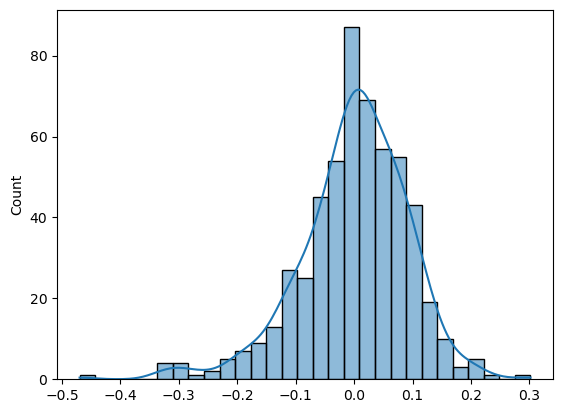

In [68]:
res = y_train - y_train_pred
sns.histplot(res, kde=True)

<span style='color:green'>Residuals are normally distributed</span>

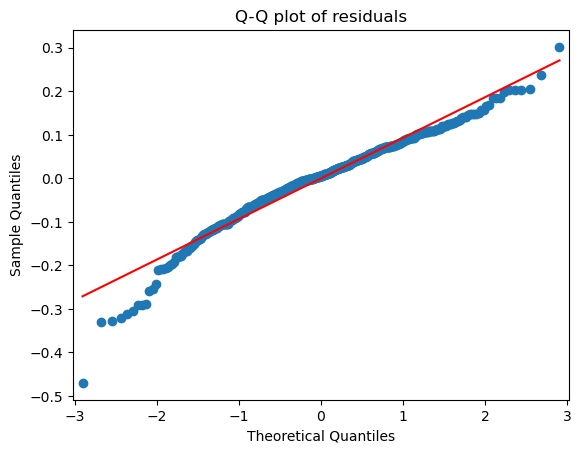

In [70]:
sm.qqplot(res, line='s')
plt.title('Q-Q plot of residuals')
plt.show()

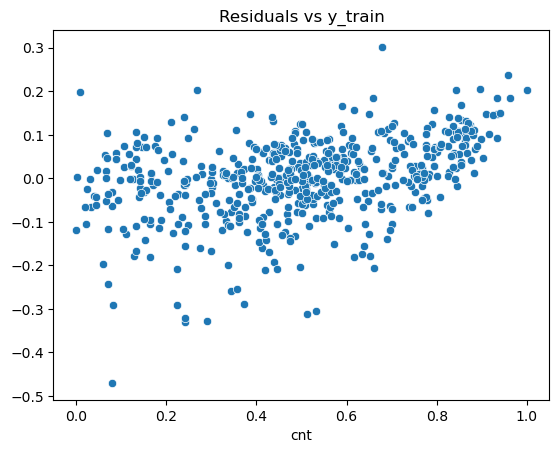

In [71]:
sns.scatterplot(x=y_train, y=res)
plt.ylabel(ylabel='')
plt.title(label='Residuals vs y_train')
plt.show()

<span style='color:green'>Residuals are randomly scattered against y_train. **No bias**</span>

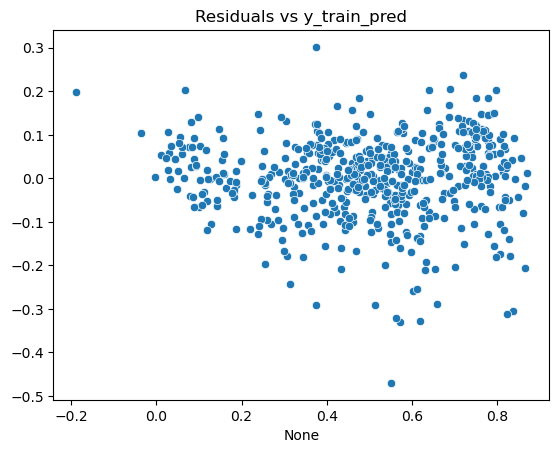

In [73]:
sns.scatterplot(x=y_train_pred, y=res)
plt.ylabel(ylabel='')
plt.title(label='Residuals vs y_train_pred')
plt.show()

<span style='color:green'>Residuals are randomly scattered against y_train_pred. **Variance is Homoscedasticity**</span>

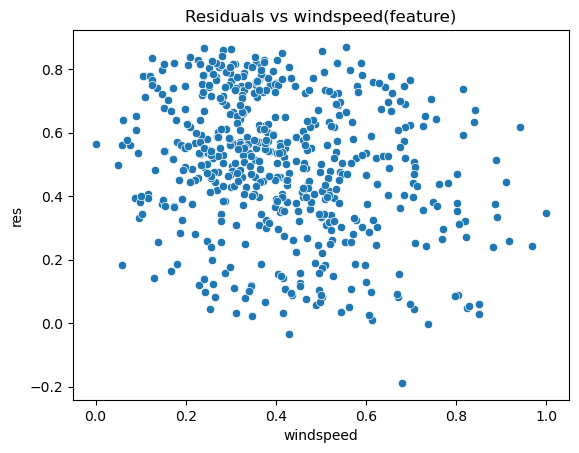

In [75]:
sns.scatterplot(y=y_train_pred, x=X_train['windspeed'])
plt.ylabel(ylabel='res')
plt.title(label='Residuals vs windspeed(feature)')
plt.show()

<span style='color:green'>Residuals are randomly scattered against a feature. **Hence no correlation**</span>

#### Linear Regression model

In [78]:
lr_1 = LinearRegression().fit(X_train, y_train)
lr_1.coef_

array([ 0.        ,  0.24105795, -0.07499103,  0.47375041, -0.1697151 ,
       -0.11320551, -0.15498099,  0.08715484, -0.21570166, -0.0556783 ,
       -0.06587122, -0.06257017,  0.04376645, -0.0823376 ,  0.06027178])

In [79]:
y_train_pred = lr_1.predict(X_train)

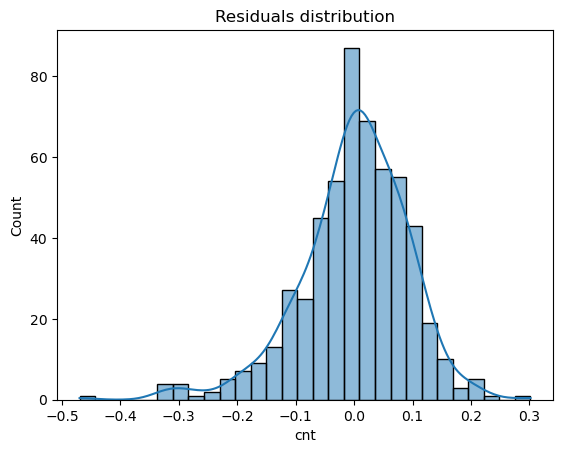

In [80]:
res2 = y_train - y_train_pred
sns.histplot(res2, kde=True)
plt.title(label='Residuals distribution')
plt.show()

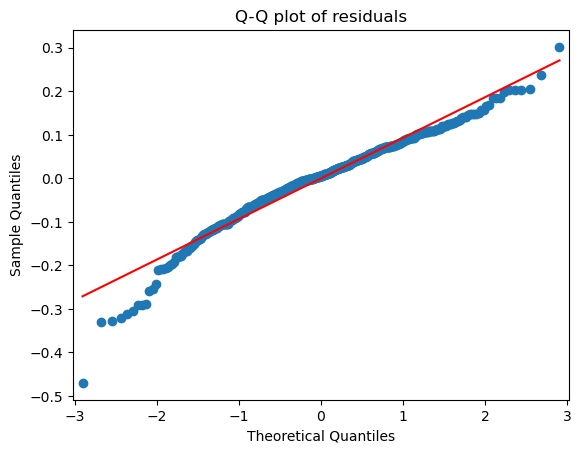

In [81]:
sm.qqplot(res2, line='s')
plt.title('Q-Q plot of residuals')
plt.show()

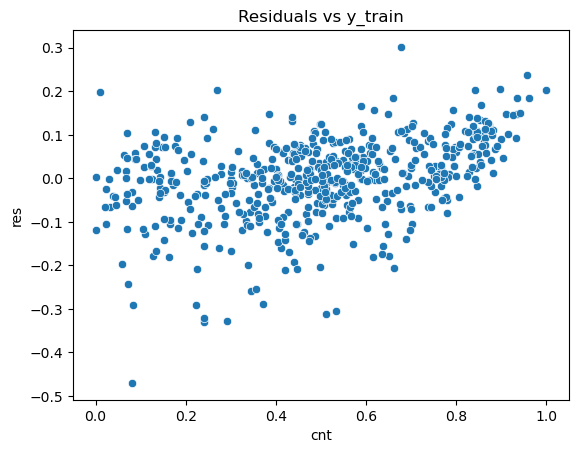

In [82]:
sns.scatterplot(y=res, x=y_train)
plt.ylabel(ylabel='res')
plt.title(label='Residuals vs y_train')
plt.show()

<span style='color:green'>Residuals are randomly scattered against y_train. **No bias**</span>

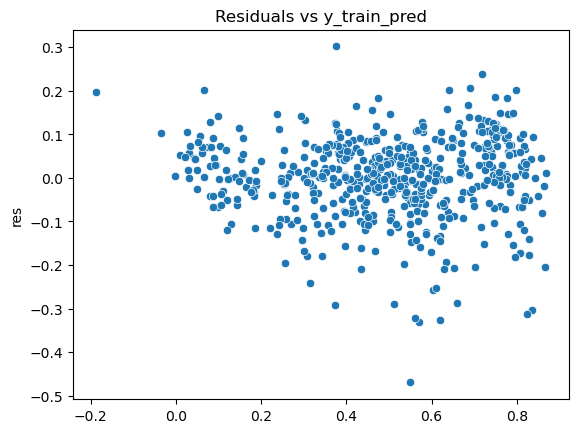

In [84]:
sns.scatterplot(y=res2, x=y_train_pred)
plt.ylabel(ylabel='res')
plt.title(label='Residuals vs y_train_pred')
plt.show()

<span style='color:green'>Residuals are randomly scattered against y_train_pred. **Variance is Homoscedasticity**</span>

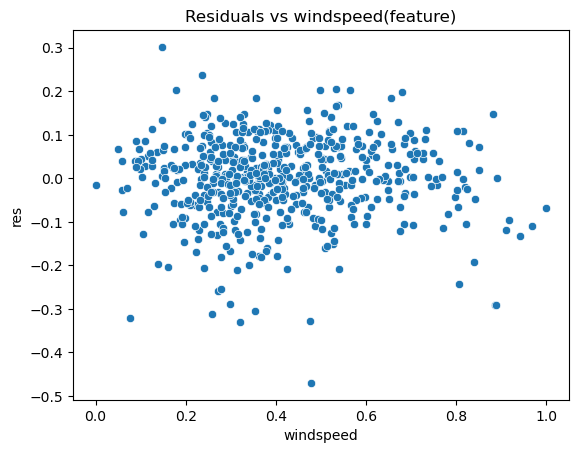

In [86]:
sns.scatterplot(y=res2, x=X_train['windspeed'])
plt.ylabel(ylabel='res')
plt.title(label='Residuals vs windspeed(feature)')
plt.show()

<span style='color:green'>Residuals are randomly scattered against a feature. **Hence no correlation**</span>

##### R2_score

In [89]:
r2_score(y_true=y_train, y_pred=y_train_pred)

0.8415274058440082

### Step 5: Evaluate and test the model

In [91]:
X_test[final_num_cols] = scaler.transform(X_test[final_num_cols])
y_test = X_test.pop('cnt')

In [92]:
y_test_pred = lr_1.predict(X_test)

In [93]:
residual_for_model = y_test - y_test_pred

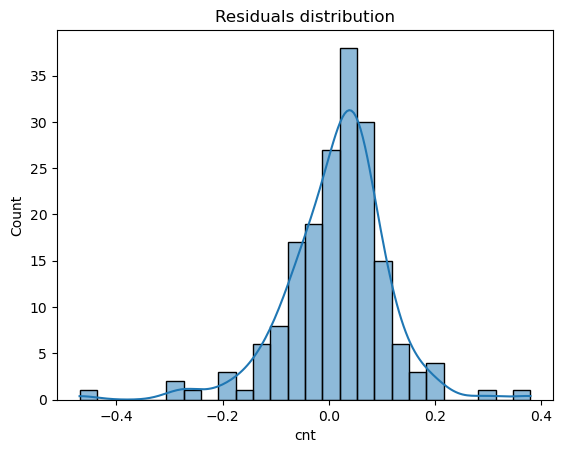

In [94]:
sns.histplot(residual_for_model, kde=True)
plt.title(label='Residuals distribution')
plt.show()
plt.show()

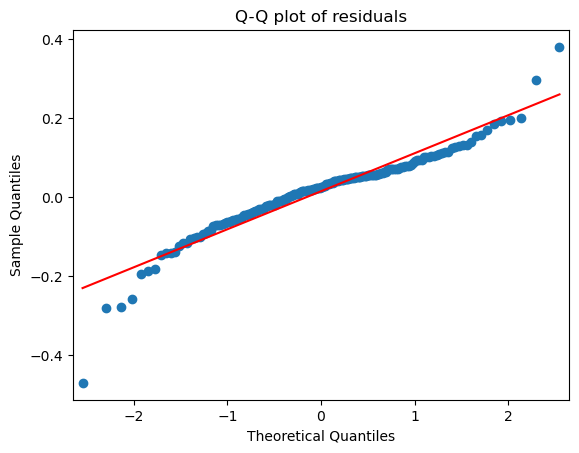

In [95]:
sm.qqplot(residual_for_model, line='s')
plt.title('Q-Q plot of residuals')
plt.show()

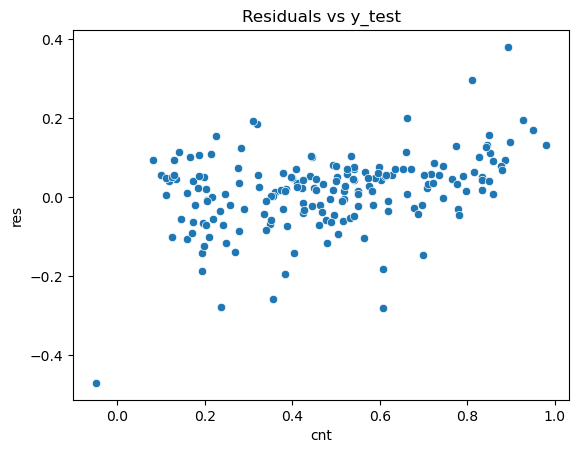

In [96]:
sns.scatterplot(y=residual_for_model, x=y_test)
plt.ylabel(ylabel='res')
plt.title(label='Residuals vs y_test')
plt.show()

<span style='color:green'>Residuals are randomly scattered against y_test. **No bias**</span>

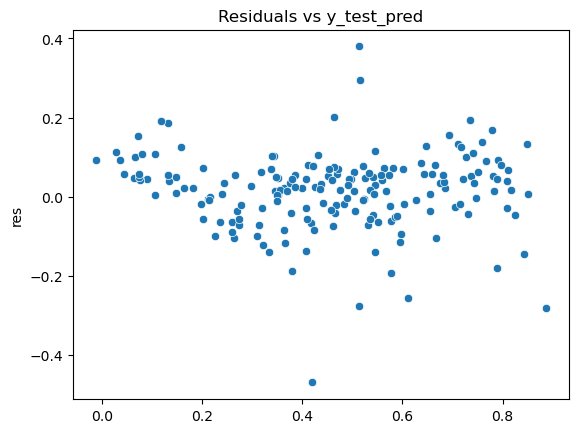

In [98]:
sns.scatterplot(y=residual_for_model, x=y_test_pred)
plt.ylabel(ylabel='res')
plt.title(label='Residuals vs y_test_pred')
plt.show()

<span style='color:green'>Residuals are randomly scattered against y_test_pred. **Variance is Homoscedasticity**</span>

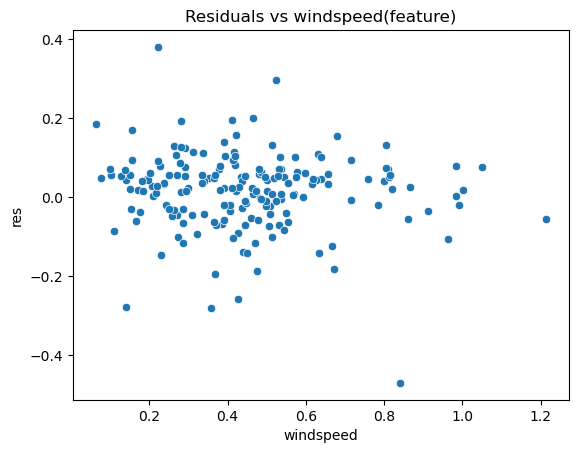

In [100]:
sns.scatterplot(y=residual_for_model, x=X_test['windspeed'])
plt.ylabel(ylabel='res')
plt.title(label='Residuals vs windspeed(feature)')
plt.show()

<span style='color:green'>Residuals are randomly scattered against a feature. **Hence no correlation**</span>

##### R2_score

In [103]:
r2_score(y_true=y_test, y_pred=y_test_pred)

0.8229422719178465

##### Subjective questions practice

In [105]:
imp_col_index = np.argsort(np.abs(lr_1.coef_))[-3:]

In [106]:
X_test.columns[imp_col_index]

Index(['Light Snow', 'yr', 'atemp'], dtype='object')

In [107]:
anscombe_df =  final_df.copy(deep=True)
cats_an = ['I', 'II', 'III', 'IV']
anscombe_df['dataset'] = [cats_an[i%4] for i in range(len(anscombe_df))]
anscombe_df = anscombe_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [108]:
anscombe_df.groupby(by='dataset').agg(['mean', 'std', 'var', 'count'])[['Light Snow', 'Tue']]

Light Snow                                 Tue                      \
              mean       std       var count      mean       std       var   
dataset                                                                      
I         0.038251  0.192329  0.036990   183  0.142077  0.350086  0.122560   
II        0.032787  0.178567  0.031886   183  0.147541  0.355617  0.126464   
III       0.021978  0.147016  0.021614   182  0.142857  0.350892  0.123125   
IV        0.021978  0.147016  0.021614   182  0.142857  0.350892  0.123125   

               
        count  
dataset        
I         183  
II        183  
III       182  
IV        182